# 基礎設定

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os, glob, json, math, shutil, zipfile, random, time
import numpy as np
import matplotlib.pyplot as plt
import cv2
from collections import Counter, defaultdict
from dataclasses import dataclass
from tqdm import tqdm
from sklearn.model_selection import StratifiedKFold
import yaml

In [ ]:
import torch
torch.backends.cudnn.benchmark = True  # 可加速，同時仍固定隨機種子

In [ ]:
# 關 W&B
os.environ["WANDB_DISABLED"] = "true"

In [ ]:
# 參數
SEED = 42
ZIP_PATH = "/content/drive/MyDrive/ComputerVision_DL/hw2_longtail_od/taica-cvpdl-2025-hw-2.zip"
EXTRACT_DIR = "/content/data_hw2"
REPORT_DIR  = "/content/reports"
os.makedirs(EXTRACT_DIR, exist_ok=True)
os.makedirs(REPORT_DIR, exist_ok=True)

In [ ]:
# 清空舊提交（可選）
shutil.rmtree("/content/submits", ignore_errors=True)
os.makedirs("/content/submits", exist_ok=True)

In [ ]:
def seed_everything(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

seed_everything(SEED)

In [ ]:
def find_dataset_root(root):
    # 方案1：直接找同層包含 train & test 的資料夾
    for dirpath, dirnames, filenames in os.walk(root):
        if 'train' in dirnames and 'test' in dirnames:
            return dirpath

    # 方案2：找任何名為 train 的資料夾，裡面有 .txt 標註檔
    candidate_trains = []
    for dirpath, dirnames, filenames in os.walk(root):
        if os.path.basename(dirpath).lower() == 'train':
            has_txt = any(fn.lower().endswith('.txt') for fn in filenames)
            has_png = any(fn.lower().endswith('.png') for fn in filenames)
            if has_txt and has_png:
                candidate_trains.append(dirpath)

    candidate_trains = sorted(candidate_trains, key=lambda d: len(d.split(os.sep)), reverse=True)

    for tdir in candidate_trains:
        parent = os.path.dirname(tdir)
        tdir_sibling_test = os.path.join(parent, 'test')
        if os.path.isdir(tdir_sibling_test):
            return parent

    return None

# 資料集

In [ ]:
with zipfile.ZipFile(ZIP_PATH, 'r') as zf:
    zf.extractall(EXTRACT_DIR)

In [ ]:
DATASET_ROOT = find_dataset_root(EXTRACT_DIR)
if DATASET_ROOT is None:
    raise RuntimeError(f"找不到包含 train/test 的資料夾，請檢查 {EXTRACT_DIR} 的解壓內容結構")

TRAIN_DIR = os.path.join(DATASET_ROOT, 'train')
TEST_DIR  = os.path.join(DATASET_ROOT, 'test')

# train: .png, .txt ；test: .png
def sorted_by_stem(paths):
    return sorted(paths, key=lambda p: os.path.splitext(os.path.basename(p))[0])

TRAIN_IMGS = sorted_by_stem(glob.glob(os.path.join(TRAIN_DIR, "*.png")))
TRAIN_TXTS = sorted_by_stem(glob.glob(os.path.join(TRAIN_DIR, "*.txt")))
TEST_IMGS  = sorted_by_stem(glob.glob(os.path.join(TEST_DIR,  "*.png")))

def stem(p): return os.path.splitext(os.path.basename(p))[0]
train_img_by_stem = {stem(p): p for p in TRAIN_IMGS}
train_lab_by_stem = {stem(p): p for p in TRAIN_TXTS}

COMMON_KEYS = sorted(set(train_img_by_stem) & set(train_lab_by_stem))
ONLY_IMG    = sorted(set(train_img_by_stem) - set(train_lab_by_stem))
ONLY_TXT    = sorted(set(train_lab_by_stem) - set(train_img_by_stem))

print(f"DATASET_ROOT: {DATASET_ROOT}")
print(f"TRAIN_DIR   : {TRAIN_DIR}")
print(f"TEST_DIR    : {TEST_DIR}")
print(f"Train images: {len(TRAIN_IMGS)} | Train labels: {len(TRAIN_TXTS)} | Test images: {len(TEST_IMGS)}")
print(f"Paired train files: {len(COMMON_KEYS)} | only_img: {len(ONLY_IMG)} | only_txt: {len(ONLY_TXT)}")



DATASET_ROOT: /content/data_hw2/CVPDL_hw2/CVPDL_hw2
TRAIN_DIR   : /content/data_hw2/CVPDL_hw2/CVPDL_hw2/train
TEST_DIR    : /content/data_hw2/CVPDL_hw2/CVPDL_hw2/test
Train images: 950 | Train labels: 950 | Test images: 550
Paired train files: 950 | only_img: 0 | only_txt: 0


## 視覺化

In [ ]:
CLASSES = ["car", "hov", "person", "motorcycle"]
COLORS = {
    0: (0/255, 176/255, 240/255),   # car
    1: (255/255, 192/255, 0/255),   # hov
    2: (146/255, 208/255, 80/255),  # person
    3: (255/255, 0/255, 0/255),     # motorcycle
}

In [ ]:
def imread_rgb(p):
    im = cv2.imread(p, cv2.IMREAD_COLOR)
    if im is None: return None
    return cv2.cvtColor(im, cv2.COLOR_BGR2RGB)

@dataclass
class BBox:
    cls: int; x: int; y: int; w: int; h: int

def parse_label_line(line):
    parts = [x.strip() for x in line.split(",")]
    if len(parts) != 5:
        return None
    try:
        c, x, y, w, h = map(int, parts)
        return BBox(c, x, y, w, h)
    except Exception:
        return None


In [ ]:
def load_label_txt(txt_path):
    items, bad_lines = [], []
    with open(txt_path, "r") as f:
        for ln, line in enumerate(f, 1):
            line = line.strip()
            if not line:
                continue
            bb = parse_label_line(line)
            if bb is None:
                bad_lines.append((ln, line))
            else:
                items.append(bb)
    return items, bad_lines

In [ ]:
def show_train_by_index(index, figsize=(8,6)):
    if not COMMON_KEYS:
        print("No paired train data.")
        return
    idx0 = index - 1
    if not (0 <= idx0 < len(COMMON_KEYS)):
        print(f"index out of range 1..{len(COMMON_KEYS)}")
        return
    k = COMMON_KEYS[idx0]
    img_p, txt_p = train_img_by_stem[k], train_lab_by_stem[k]
    im = imread_rgb(img_p)
    items, _ = load_label_txt(txt_p)

    fig, ax = plt.subplots(1,1, figsize=figsize)
    ax.imshow(im); ax.axis("off")
    ax.set_title(f"[TRAIN #{index}] {os.path.basename(img_p)} (boxes={len(items)})")
    for it in items:
        rect = plt.Rectangle((it.x, it.y), it.w, it.h, fill=False, lw=2, ec=COLORS.get(it.cls, (1,1,1)))
        ax.add_patch(rect)
        name = CLASSES[it.cls] if 0 <= it.cls < len(CLASSES) else f"cls{it.cls}"
        ax.text(it.x, max(0, it.y-3), name, fontsize=9, color=COLORS.get(it.cls, (1,1,1)),
                bbox=dict(facecolor=(0,0,0,0.5), edgecolor='none', pad=1))
    plt.show()

In [ ]:
def show_test_by_index(index, figsize=(8,6)):
    if not TEST_IMGS:
        print("No test images.")
        return
    idx0 = index - 1
    if not (0 <= idx0 < len(TEST_IMGS)):
        print(f"index out of range 1..{len(TEST_IMGS)}")
        return
    img_p = TEST_IMGS[idx0]
    im = imread_rgb(img_p)
    plt.figure(figsize=figsize)
    plt.imshow(im); plt.axis("off")
    plt.title(f"[TEST #{index}] {os.path.basename(img_p)}")
    plt.show()

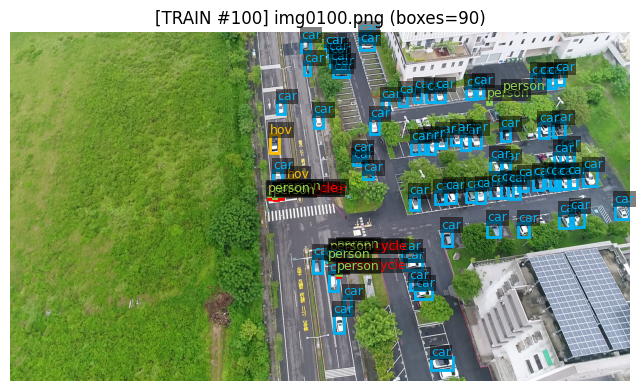

In [ ]:
show_train_by_index(100)

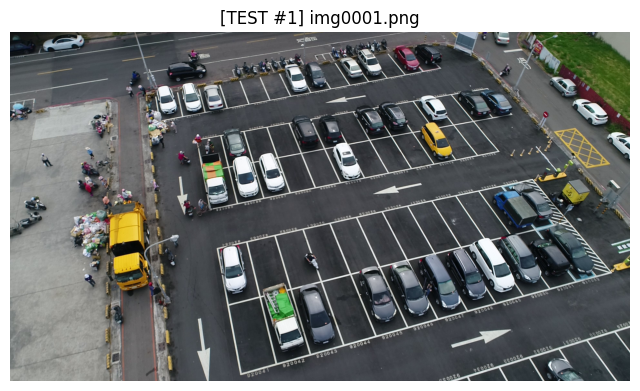

In [ ]:
show_test_by_index(1)

# 前處理

In [ ]:
# 基本影像尺寸快取
DIM_CACHE = {}
def get_hw(img_path):
    if img_path in DIM_CACHE:
        return DIM_CACHE[img_path]
    im = imread_rgb(img_path)
    if im is None:
        return None
    h, w = im.shape[:2]
    DIM_CACHE[img_path] = (h, w)
    return h, w

In [ ]:
# 檢查
MIN_SIDE_PX = 2                # 寬/高 < 2 視為極小
MIN_AREA_PX = 4                # 也可用面積判斷
VALID_CLASS_IDS = set(range(len(CLASSES)))
DUP_IOU_THR = 0.9              # 大於此 IoU 視為重複框（可能是同物件多框）
TINY_AREA_RATIO = 1e-5         # 相對影像面積（例如 <0.001%）


In [ ]:
def iou_xywh(a, b):
    ax1, ay1, ax2, ay2 = a.x, a.y, a.x + a.w, a.y + a.h
    bx1, by1, bx2, by2 = b.x, b.y, b.x + b.w, b.y + b.h
    ix1, iy1 = max(ax1, bx1), max(ay1, by1)
    ix2, iy2 = min(ax2, bx2), min(ay2, by2)
    iw, ih = max(0, ix2 - ix1), max(0, iy2 - iy1)
    inter = iw * ih
    if inter <= 0: return 0.0
    a_area = a.w * a.h
    b_area = b.w * b.h
    union = a_area + b_area - inter + 1e-6
    return inter / union

def clip_bbox(bb, W, H):
    x1 = max(0, min(bb.x, W-1))
    y1 = max(0, min(bb.y, H-1))
    x2 = max(0, min(bb.x + bb.w, W))
    y2 = max(0, min(bb.y + bb.h, H))
    w = max(0, x2 - x1)
    h = max(0, y2 - y1)
    return BBox(bb.cls, x1, y1, w, h)

In [ ]:
# 產報表
import csv

bad_rows = []     # 壞行或無法解析
invalid_cls = []  # 類別越界
nonpos_wh = []    # w/h <= 0
oob_boxes = []    # 超出邊界
tiny_boxes = []   # 極小框
dup_boxes  = []   # 重複框（高 IoU）

per_image_class_count = defaultdict(lambda: Counter())
size_buckets = Counter()  # small/medium/large

In [ ]:
def bucket_by_area_ratio(w, h, W, H):
    ratio = (w * h) / float(W * H + 1e-6)
    if ratio < 0.001:  # <0.1% of image
        return "small"
    elif ratio < 0.01: # <1%
        return "medium"
    else:
        return "large"

In [ ]:
for k in COMMON_KEYS:
    img_p, txt_p = train_img_by_stem[k], train_lab_by_stem [k]
    dim = get_hw(img_p)
    if dim is None:
        bad_rows.append([k, "image_read_fail", "", ""])
        continue
    H, W = dim
    items, bads = load_label_txt(txt_p)
    for (ln, line) in bads:
        bad_rows.append([k, "parse_fail", ln, line])

    # 類別統計 + 基本檢查
    for it in items:
        per_image_class_count[k][it.cls] += 1
        if it.cls not in VALID_CLASS_IDS:
            invalid_cls.append([k, it.cls])

        if it.w <= 0 or it.h <= 0:
            nonpos_wh.append([k, it.cls, it.x, it.y, it.w, it.h])

        # 越界
        if not (0 <= it.x < W and 0 <= it.y < H and it.x + it.w <= W + 1 and it.y + it.h <= H + 1):
            oob_boxes.append([k, it.cls, it.x, it.y, it.w, it.h, W, H])

        # 極小框
        if it.w < MIN_SIDE_PX or it.h < MIN_SIDE_PX or (it.w * it.h) < MIN_AREA_PX:
            tiny_boxes.append([k, it.cls, it.x, it.y, it.w, it.h])
        else:
            size_buckets[bucket_by_area_ratio(it.w, it.h, W, H)] += 1

    # 重複框檢測（同類別內）
    for c in set([it.cls for it in items]):
        cls_items = [it for it in items if it.cls == c and it.w > 0 and it.h > 0]
        n = len(cls_items)
        for i in range(n):
            for j in range(i+1, n):
                if iou_xywh(cls_items[i], cls_items[j]) > DUP_IOU_THR:
                    dup_boxes.append([k, c, i, j])


In [ ]:
# 輸出報表
def write_csv(path, header, rows):
    with open(path, "w", newline="") as f:
        w = csv.writer(f)
        w.writerow(header); w.writerows(rows)

write_csv(os.path.join(REPORT_DIR, "bad_rows.csv"),
          ["stem", "reason", "line_no", "raw_line"], bad_rows)

write_csv(os.path.join(REPORT_DIR, "invalid_class.csv"),
          ["stem", "cls"], invalid_cls)

write_csv(os.path.join(REPORT_DIR, "nonpos_wh.csv"),
          ["stem", "cls", "x", "y", "w", "h"], nonpos_wh)

write_csv(os.path.join(REPORT_DIR, "out_of_bounds.csv"),
          ["stem", "cls", "x", "y", "w", "h", "W", "H"], oob_boxes)

write_csv(os.path.join(REPORT_DIR, "tiny_boxes.csv"),
          ["stem", "cls", "x", "y", "w", "h"], tiny_boxes)

write_csv(os.path.join(REPORT_DIR, "duplicate_boxes.csv"),
          ["stem", "cls", "idx_i", "idx_j"], dup_boxes)

In [ ]:
# 類別分佈
class_counts = Counter()
for k, cnt in per_image_class_count.items():
    for c, v in cnt.items():
        class_counts[c] += v

stats = {
    "class_counts": {CLASSES[c]: int(class_counts[c]) for c in range(len(CLASSES))},
    "size_buckets": dict(size_buckets),
    "num_train_pairs": len(COMMON_KEYS),
    "only_img": len(ONLY_IMG),
    "only_txt": len(ONLY_TXT),
}
with open(os.path.join(REPORT_DIR, "dataset_stats.json"), "w") as f:
    json.dump(stats, f, indent=2)
print(json.dumps(stats, indent=2))
print(f"Reports saved under: {REPORT_DIR}")

{
  "class_counts": {
    "car": 23275,
    "hov": 1345,
    "person": 3363,
    "motorcycle": 5348
  },
  "size_buckets": {
    "small": 23201,
    "medium": 9891,
    "large": 239
  },
  "num_train_pairs": 950,
  "only_img": 0,
  "only_txt": 0
}
Reports saved under: /content/reports


In [ ]:
# labels_clean
CLEAN_LAB_DIR = os.path.join(EXTRACT_DIR, "train", "labels_clean")
os.makedirs(CLEAN_LAB_DIR, exist_ok=True)

def dedup_by_iou(items, thr=0.9):
    kept = []
    items_sorted = sorted(items, key=lambda b: b.w*b.h, reverse=True)  # 先保留大框
    for bb in items_sorted:
        drop = False
        for kk in kept:
            if bb.cls == kk.cls and iou_xywh(bb, kk) > thr:
                drop = True; break
        if not drop:
            kept.append(bb)
    return kept

num_changed = 0
for k in COMMON_KEYS:
    img_p, txt_p = train_img_by_stem[k], train_lab_by_stem[k]
    dim = get_hw(img_p)
    if dim is None:
        continue
    H, W = dim
    items, _ = load_label_txt(txt_p)

    # clip & basic filter
    fixed = []
    for it in items:
        it2 = clip_bbox(it, W, H)
        if it2.w <= 0 or it2.h <= 0:
            continue
        # 你可用 tiny 判準做 stricter 過濾
        if it2.w < MIN_SIDE_PX or it2.h < MIN_SIDE_PX:
            continue
        fixed.append(it2)

    # 去重
    fixed2 = dedup_by_iou(fixed, thr=DUP_IOU_THR)

    # 寫出
    out_p = os.path.join(CLEAN_LAB_DIR, f"{k}.txt")
    with open(out_p, "w") as f:
        for b in fixed2:
            f.write(f"{b.cls},{b.x},{b.y},{b.w},{b.h}\n")

    if len(fixed2) != len(items):
        num_changed += 1

print(f"Cleaned labels saved under: {CLEAN_LAB_DIR} | files_changed: {num_changed}")

Cleaned labels saved under: /content/data_hw2/train/labels_clean | files_changed: 0


## 檢查類別不平衡

In [ ]:
# 類別存在向量，用於分層切分
has_tail = []   # [(stem, [0/1 for each class])]
for k in COMMON_KEYS:
    txt_p = train_lab_by_stem[k]
    items, _ = load_label_txt(txt_p)
    vec = [0]*len(CLASSES)
    for it in items:
        if 0 <= it.cls < len(CLASSES):
            vec[it.cls] = 1
    has_tail.append((k, vec))

In [ ]:
no_hov = sum(1 for _,v in has_tail if v[1]==0)
no_person = sum(1 for _,v in has_tail if v[2]==0)
print(f"Images w/o hov: {no_hov} / {len(COMMON_KEYS)}")
print(f"Images w/o person: {no_person} / {len(COMMON_KEYS)}")


Images w/o hov: 387 / 950
Images w/o person: 437 / 950


In [ ]:
# 5-fold: 保證尾類覆蓋
from sklearn.model_selection import StratifiedKFold

In [ ]:
# 以「類別存在模式」轉為一個整數 key 來分層（例如 4 類 -> 0..15）
def pattern_id(vec):
    pid = 0
    for i,b in enumerate(vec):
        pid |= (int(b) << i)
    return pid

X = [k for k,_ in has_tail]
y = [pattern_id(v) for _,v in has_tail]

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
folds = []
for fi, (tr_idx, va_idx) in enumerate(skf.split(X, y)):
    tr_keys = [X[i] for i in tr_idx]
    va_keys = [X[i] for i in va_idx]
    folds.append({"train": tr_keys, "val": va_keys})

with open(os.path.join(REPORT_DIR, "folds_5.json"), "w") as f:
    json.dump(folds, f, indent=2)

print("5-fold splits saved ->", os.path.join(REPORT_DIR, "folds_5.json"))

5-fold splits saved -> /content/reports/folds_5.json


/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


## 算看看IR

*   課堂教max 跟min 差3~5倍可以接受



In [ ]:
# ===== Cell D1: 類別分佈與不平衡度 =====
cls_counter = Counter()
for k in COMMON_KEYS:
    items, _ = load_label_txt(train_lab_by_stem[k])
    for it in items:
        if 0 <= it.cls < len(CLASSES):
            cls_counter[it.cls] += 1

print("\n[Class Counts]")
counts = [cls_counter[c] for c in range(len(CLASSES))]
for cid, name in enumerate(CLASSES):
    print(f"  {name:12s}: {counts[cid]}")


[Class Counts]
  car         : 23275
  hov         : 1345
  person      : 3363
  motorcycle  : 5348


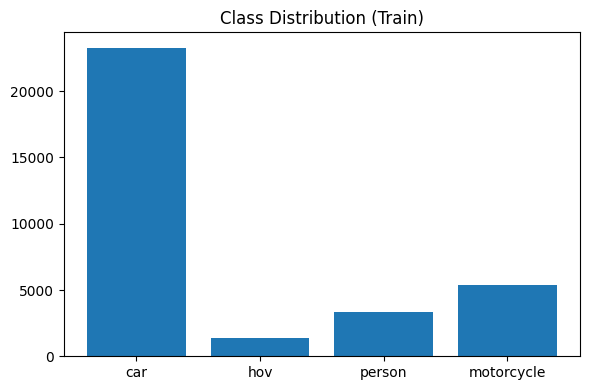

In [ ]:
plt.figure(figsize=(6,4))
x = np.arange(len(CLASSES))
plt.bar(x, counts)
plt.xticks(x, CLASSES)
plt.title("Class Distribution (Train)")
plt.tight_layout()
plt.show()

In [ ]:
nonzero = [c for c in counts if c>0]
imbalance_rate = (max(nonzero)/min(nonzero)) if len(nonzero)>=2 else float('inf')
total = sum(counts)
props = [c/total if total>0 else 0 for c in counts]
print("\n[Imbalance]")
print(f"  total boxes       : {total}")
print(f"  imbalance rate    : {imbalance_rate:.3f}")
print("  class proportions :")
for name, p in zip(CLASSES, props):
    print(f"    {name:12s}: {p:.4f}")


[Imbalance]
  total boxes       : 33331
  imbalance rate    : 17.305
  class proportions :
    car         : 0.6983
    hov         : 0.0404
    person      : 0.1009
    motorcycle  : 0.1605


# YOLOv8標註: cxcywh 正規化

In [ ]:
# 優先使用清理後標註；否則使用原標註
CLEAN_LAB_DIR = os.path.join(DATASET_ROOT, "labels_clean")
USE_LAB_DIR   = CLEAN_LAB_DIR if os.path.isdir(CLEAN_LAB_DIR) and len(glob.glob(os.path.join(CLEAN_LAB_DIR, "*.txt"))) > 0 \
                else TRAIN_DIR
print("Using labels from:", USE_LAB_DIR)

YOLO_ROOT = "/content/yolo_dataset"
IMG_DIR   = os.path.join(YOLO_ROOT, "images")   # 存放全量訓練影像（之後折分時引用）
LAB_DIR   = os.path.join(YOLO_ROOT, "labels")   # 對應 YOLO 標註（cx cy w h，0~1）

shutil.rmtree(YOLO_ROOT, ignore_errors=True)
os.makedirs(IMG_DIR, exist_ok=True)
os.makedirs(LAB_DIR, exist_ok=True)


Using labels from: /content/data_hw2/CVPDL_hw2/CVPDL_hw2/train


In [ ]:
# 快速讀影像尺寸
_DIM_CACHE = {}
def get_hw(img_path):
    if img_path in _DIM_CACHE: return _DIM_CACHE[img_path]
    im = cv2.imread(img_path, cv2.IMREAD_COLOR)
    if im is None: return None
    h, w = im.shape[:2]
    _DIM_CACHE[img_path] = (h, w)
    return h, w

def load_items_txt(txt_path):
    items = []
    with open(txt_path, "r") as f:
        for line in f:
            line = line.strip()
            if not line: continue
            parts = [x.strip() for x in line.split(",")]
            if len(parts) != 5: continue
            c, x, y, w, h = map(int, parts)
            items.append((c, x, y, w, h))
    return items

# 轉換為 YOLO 標註格式
num_ok, num_skip = 0, 0
for k in tqdm(COMMON_KEYS, desc="Convert to YOLO labels"):
    src_img = train_img_by_stem[k]
    src_lab = os.path.join(USE_LAB_DIR, f"{k}.txt")
    if not os.path.isfile(src_img) or not os.path.isfile(src_lab):
        num_skip += 1
        continue

    hw = get_hw(src_img)
    if hw is None:
        num_skip += 1
        continue
    H, W = hw

    # 複製影像到 YOLO_ROOT/images
    dst_img = os.path.join(IMG_DIR, f"{k}.png")
    if not os.path.isfile(dst_img):
        shutil.copy2(src_img, dst_img)

    # 讀原標註、寫 YOLO 格式
    items = load_items_txt(src_lab)
    yolo_lines = []
    for (c, x, y, w, h) in items:
        if w <= 0 or h <= 0:
            continue
        # 轉中心 & 正規化
        cx, cy = x + w/2, y + h/2
        yolo_cx = cx / W
        yolo_cy = cy / H
        yolo_w  = w / W
        yolo_h  = h / H
        # clip 到 [0,1]
        yolo_cx = min(1, max(0, yolo_cx))
        yolo_cy = min(1, max(0, yolo_cy))
        yolo_w  = min(1, max(0, yolo_w))
        yolo_h  = min(1, max(0, yolo_h))
        yolo_lines.append(f"{c} {yolo_cx:.6f} {yolo_cy:.6f} {yolo_w:.6f} {yolo_h:.6f}")

    with open(os.path.join(LAB_DIR, f"{k}.txt"), "w") as f:
        f.write("\n".join(yolo_lines))
    num_ok += 1

print(f"Converted: {num_ok} | Skipped: {num_skip}")
print("YOLO dataset root:", YOLO_ROOT)

Convert to YOLO labels: 100%|██████████| 950/950 [01:02<00:00, 15.10it/s]

Converted: 950 | Skipped: 0
YOLO dataset root: /content/yolo_dataset


# 5-Fold 分層切分

*   確保每fold 都有各類別



In [ ]:
REPORT_DIR = "/content/reports"
os.makedirs(REPORT_DIR, exist_ok=True)

In [ ]:
# 多標籤分層>> deal with "least-populated class"
!pip install scikit-multilearn -q
from skmultilearn.model_selection import IterativeStratification

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.4/89.4 kB 4.2 MB/s eta 0:00:00


In [ ]:
# 建立 (樣本鍵 -> 類別統計)、與類別存在向量
cls_counts_per_img = {}
presence_vector = {}
for k in COMMON_KEYS:
    lab_p = os.path.join(LAB_DIR, f"{k}.txt")
    cnt = Counter()
    vec = [0]*len(CLASSES)
    if os.path.isfile(lab_p):
        with open(lab_p, "r") as f:
            for line in f:
                line=line.strip()
                if not line: continue
                cid = int(line.split()[0])
                cnt[cid]+=1
                vec[cid]=1
    cls_counts_per_img[k]=cnt
    presence_vector[k]=vec

def pattern_id(vec):
    pid=0
    for i,b in enumerate(vec):
        pid |= (int(b) << i)
    return pid

X = list(COMMON_KEYS)
Y = np.array([presence_vector[k] for k in X], dtype=int)

mskf = IterativeStratification(n_splits=5, order=1)
folds = []
for tr_idx, va_idx in mskf.split(X, Y):
    tr_keys = [X[i] for i in tr_idx]
    va_keys = [X[i] for i in va_idx]
    folds.append({"train": tr_keys, "val": va_keys})

with open(os.path.join(REPORT_DIR, "folds_5.json"), "w") as f:
    json.dump(folds, f, indent=2)
print("Saved 5 multilabel folds ->", os.path.join(REPORT_DIR, "folds_5.json"))


Saved 5 multilabel folds -> /content/reports/folds_5.json


# DownSampling: car (*0.7)

In [ ]:
# 下採樣設定
# presence_vector 來自前面：每張圖的類別存在 0/1 向量
HEAD_ONLY = [k for k,v in presence_vector.items() if v[0]==1 and sum(v[1:])==0]
HEAD_KEEP = 0.7  # car 70%

def downsample_head_only(keys):
    heads = [k for k in keys if k in HEAD_ONLY]
    others = [k for k in keys if k not in HEAD_ONLY]
    keep_n = int(len(heads) * HEAD_KEEP)
    kept_head = random.sample(heads, keep_n) if keep_n < len(heads) else heads
    return others + kept_head

# 對每折的 train 做一次下採樣（val 不動）
for f in folds:
    f["train"] = downsample_head_only(f["train"])

# Upsampling: RFS
*   根據每張圖裡包含的類別頻率動態決定重複次數


In [ ]:
# === 【修改】RFS：尾類提升更高門檻 + 放寬上限 ===
# 估計類別頻率
global_cls_counts = Counter()
for k in COMMON_KEYS:
    global_cls_counts.update(cls_counts_per_img[k])

eps=1e-9 # 避免除零
total_boxes = sum(global_cls_counts.values()) + eps
freq = {c: (global_cls_counts[c]/total_boxes) for c in range(len(CLASSES))}

repeat_thresh_per_class = {
    1: 0.006,   # hov
    2: 0.010,   # person（最弱，最高）
    3: 0.008    # motorcycle
}
BASE_T = 0.002
RFS_CAP = 3.0

def image_repeat_factor(k):
    # LVIS-like per-class threshold
    max_r = 1.0
    for c, n in cls_counts_per_img[k].items():
        t = repeat_thresh_per_class.get(c, BASE_T)
        fc = freq.get(c, 1e-9)
        r = math.sqrt(t / max(fc, 1e-9))
        max_r = max(max_r, r)
    return min(max_r, RFS_CAP)

LIST_DIR = os.path.join(YOLO_ROOT, "splits")
os.makedirs(LIST_DIR, exist_ok=True)

def img_path_of(k): return os.path.join(IMG_DIR, f"{k}.png")
def lab_path_of(k): return os.path.join(LAB_DIR, f"{k}.txt")

for fi, fold in enumerate(folds):
    tr, va = fold["train"], fold["val"]

    # 基本清單
    with open(os.path.join(LIST_DIR, f"fold{fi}_train.txt"), "w") as f:
        for k in tr:
            f.write(img_path_of(k) + "\n")
    with open(os.path.join(LIST_DIR, f"fold{fi}_val.txt"), "w") as f:
        for k in va:
            f.write(img_path_of(k) + "\n")

    # RFS 清單（影像路徑重複）
    with open(os.path.join(LIST_DIR, f"fold{fi}_train_rfs.txt"), "w") as f:
        for k in tr:
            r = image_repeat_factor(k)
            n_rep = int(round(r))
            for _ in range(max(1,n_rep)):
                f.write(img_path_of(k) + "\n")

print("Generated split lists under:", LIST_DIR)

Generated split lists under: /content/yolo_dataset/splits


# Copy-Paste 資料增強
*   從原圖裁切出來，隨機貼回到其他影像中
*   為避免汙染原始資料，另建 yolo_dataset_aug/

In [ ]:
AUG_ROOT = "/content/yolo_dataset_aug"
AUG_IMG_DIR = os.path.join(AUG_ROOT, "images")
AUG_LAB_DIR = os.path.join(AUG_ROOT, "labels")
shutil.rmtree(AUG_ROOT, ignore_errors=True)
os.makedirs(AUG_IMG_DIR, exist_ok=True)
os.makedirs(AUG_LAB_DIR, exist_ok=True)

# 尾類 ID（排除 car=0）
TAIL_IDS = [1,2,3]  # hov/person/motorcycle

# 蒐集尾類 instance（以「像素框裁切」簡單版；若要更精緻可加 GrabCut）
INSTANCES = []  # (cls, crop_image)
for k in COMMON_KEYS:
    img_p = os.path.join(IMG_DIR, f"{k}.png")
    lab_p = os.path.join(LAB_DIR, f"{k}.txt")
    im = cv2.imread(img_p, cv2.IMREAD_COLOR)
    if im is None or not os.path.isfile(lab_p): continue
    H,W = im.shape[:2]
    with open(lab_p, "r") as f:
        for line in f:
            parts=line.strip().split()
            if len(parts)!=5: continue
            c=int(parts[0]); cx,cy,ww,hh = map(float, parts[1:])
            if c not in TAIL_IDS: continue
            x = int((cx - ww/2)*W); y = int((cy - hh/2)*H)
            w = int(ww*W);        h = int(hh*H)
            x = max(0, min(x, W-1)); y=max(0, min(y, H-1))
            w = max(1, min(w, W-x)); h=max(1, min(h, H-y))
            crop = im[y:y+h, x:x+w].copy()
            if crop.size>0 and min(w,h)>=4:
                INSTANCES.append((c, crop))

print("Collected tail instances:", len(INSTANCES))

Collected tail instances: 9971


In [ ]:
def random_light_jitter(img):
    # 輕微亮度/對比擾動
    img = img.astype(np.float32)
    alpha = np.random.uniform(0.9, 1.1)
    beta  = np.random.uniform(-8, 8)
    out = np.clip(img*alpha + beta, 0, 255).astype(np.uint8)
    return out

def random_motion_blur(img, k=3):
    if random.random()<0.5: return img
    # 水平或垂直
    kernel = np.zeros((k,k))
    if random.random()<0.5:
        kernel[int((k-1)/2), :] = np.ones(k)
    else:
        kernel[:, int((k-1)/2)] = np.ones(k)
    kernel = kernel / k
    return cv2.filter2D(img, -1, kernel)

AUG_PER_IMAGE_BASE = 1
AUG_PER_IMAGE_IF_NO_TAIL = 2
PERSON_SMALL_SCALE = (0.6, 1.0)
OTHERS_SCALE       = (0.8, 1.2)

def need_more_tail(vec):  # vec = presence_vector[k]
    return (vec[1]==0) or (vec[2]==0) or (vec[3]==0)

aug_count=0
for k in tqdm(COMMON_KEYS, desc="Tail Copy-Paste++"):
    bg_img_p = os.path.join(IMG_DIR, f"{k}.png")
    bg_lab_p = os.path.join(LAB_DIR, f"{k}.txt")
    bg = cv2.imread(bg_img_p, cv2.IMREAD_COLOR)
    if bg is None: continue
    H, W = bg.shape[:2]

    boxes=[]
    if os.path.isfile(bg_lab_p):
        with open(bg_lab_p, "r") as f:
            for line in f:
                p=line.strip().split()
                if len(p)!=5: continue
                c=int(p[0]); cx,cy,ww,hh = map(float, p[1:])
                boxes.append([c,cx,cy,ww,hh])

    vec = presence_vector.get(k, [0,0,0,0])
    n_add = AUG_PER_IMAGE_IF_NO_TAIL if need_more_tail(vec) else AUG_PER_IMAGE_BASE

    pasted=[]
    for _ in range(n_add):
        if not INSTANCES: break
        c, crop = random.choice(INSTANCES)
        scale_min, scale_max = PERSON_SMALL_SCALE if c==2 else OTHERS_SCALE
        scale = np.random.uniform(scale_min, scale_max)
        nh, nw = int(crop.shape[0]*scale), int(crop.shape[1]*scale)
        if nh<4 or nw<4: continue
        patch = cv2.resize(crop, (nw, nh), interpolation=cv2.INTER_LINEAR)
        patch = random_light_jitter(patch)
        patch = random_motion_blur(patch, k=3)

        max_x = max(1, W - nw - 1)
        max_y = max(1, H - nh - 1)
        px = random.randint(0, max_x)
        py = random.randint(0, max_y)
        bg[py:py+nh, px:px+nw] = patch

        cx = (px + nw/2) / W
        cy = (py + nh/2) / H
        ww = nw / W
        hh = nh / H
        pasted.append([c, cx, cy, ww, hh])

    if not pasted:
        continue

    new_key = f"{k}_aug"
    out_img = os.path.join(AUG_IMG_DIR, f"{new_key}.png")
    out_lab = os.path.join(AUG_LAB_DIR, f"{new_key}.txt")
    cv2.imwrite(out_img, bg)
    all_boxes = boxes + pasted
    with open(out_lab, "w") as f:
        for c,cx,cy,ww,hh in all_boxes:
            f.write(f"{c} {cx:.6f} {cy:.6f} {ww:.6f} {hh:.6f}\n")
    aug_count += 1

print("Augmented images:", aug_count)

Tail Copy-Paste++: 100%|██████████| 950/950 [02:58<00:00,  5.32it/s]

Augmented images: 945


# 生成每個 Fold 的 data.yaml（含 RFS + Aug）

In [ ]:
DATA_YAML_DIR = os.path.join(YOLO_ROOT, "yamls")
os.makedirs(DATA_YAML_DIR, exist_ok=True)

def write_list(paths, out_txt):
    with open(out_txt, "w") as f:
        f.write("\n".join(paths))

AUG_IMGS = sorted(glob.glob(os.path.join(AUG_IMG_DIR, "*.png")))
AUG_KEYS = [os.path.splitext(os.path.basename(p))[0] for p in AUG_IMGS]

for fi in range(5):
    base_train = os.path.join(YOLO_ROOT, "splits", f"fold{fi}_train.txt")
    base_val   = os.path.join(YOLO_ROOT, "splits", f"fold{fi}_val.txt")
    base_rfs   = os.path.join(YOLO_ROOT, "splits", f"fold{fi}_train_rfs.txt")

    with open(base_rfs, "r") as f:
        rfs_paths = [ln.strip() for ln in f if ln.strip()]

    # 把離線 Aug 的影像也加入訓練（不重覆）
    train_paths = list(rfs_paths)
    train_paths += [p for p in AUG_IMGS]  # 直接加整包，比例已經不大

    train_list_out = os.path.join(YOLO_ROOT, "splits", f"fold{fi}_train_final.txt")
    shutil.copy2(base_val, os.path.join(YOLO_ROOT, "splits", f"fold{fi}_val_final.txt"))
    write_list(train_paths, train_list_out)

    yaml_path = os.path.join(DATA_YAML_DIR, f"fold{fi}.yaml")
    with open(yaml_path, "w") as f:
        f.write(f"""
# auto-generated data.yaml for fold {fi}
path: {YOLO_ROOT}
train: {train_list_out}
val: {os.path.join(YOLO_ROOT, "splits", f"fold{fi}_val_final.txt")}
names:
  0: car
  1: hov
  2: person
  3: motorcycle
""")
    print("Wrote", yaml_path)

Wrote /content/yolo_dataset/yamls/fold0.yaml
Wrote /content/yolo_dataset/yamls/fold1.yaml
Wrote /content/yolo_dataset/yamls/fold2.yaml
Wrote /content/yolo_dataset/yamls/fold3.yaml
Wrote /content/yolo_dataset/yamls/fold4.yaml


In [ ]:
import yaml, os

YAML_DIR = "/content/yolo_dataset/yamls"
class_names = ["car", "hov", "person", "motorcycle"]

for fi in range(5):
    yaml_path = os.path.join(YAML_DIR, f"fold{fi}.yaml")
    if not os.path.isfile(yaml_path):
        print(f"⚠️ 找不到 {yaml_path}，略過")
        continue

    with open(yaml_path, "r") as f:
        data = yaml.safe_load(f)

    data["nc"] = len(class_names)
    data["names"] = class_names

    with open(yaml_path, "w") as f:
        yaml.safe_dump(data, f, sort_keys=False)

    print(f"✅ fold{fi}.yaml 已修正完成 → nc={len(class_names)}, names={class_names}")

print("🎯 全部 fold0~fold4.yaml 修正完成")


✅ fold0.yaml 已修正完成 → nc=4, names=['car', 'hov', 'person', 'motorcycle']
✅ fold1.yaml 已修正完成 → nc=4, names=['car', 'hov', 'person', 'motorcycle']
✅ fold2.yaml 已修正完成 → nc=4, names=['car', 'hov', 'person', 'motorcycle']
✅ fold3.yaml 已修正完成 → nc=4, names=['car', 'hov', 'person', 'motorcycle']
✅ fold4.yaml 已修正完成 → nc=4, names=['car', 'hov', 'person', 'motorcycle']
🎯 全部 fold0~fold4.yaml 修正完成


# 模型架構


*   YOLOv8n_p2
*   無預訓練

In [ ]:
!pip -q install ultralytics==8.3.204

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 19.5 MB/s eta 0:00:00


In [ ]:
import os, textwrap, yaml, json, torch
from ultralytics import YOLO

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [ ]:
%%writefile /content/yolov8n_p2.yaml
# YOLOv8n_p2.yaml - 修正版，支援小物件、通道正確對齊
nc: 4

backbone:
  - [-1, 1, Conv, [32, 3, 2]]      # 0-P1/2
  - [-1, 1, Conv, [64, 3, 2]]      # 1-P2
  - [-1, 3, C2f,  [64, True]]      # 2
  - [-1, 1, Conv, [128, 3, 2]]     # 3-P3
  - [-1, 6, C2f,  [128, True]]     # 4
  - [-1, 1, Conv, [256, 3, 2]]     # 5-P4
  - [-1, 6, C2f,  [256, True]]     # 6
  - [-1, 1, Conv, [512, 3, 2]]     # 7-P5
  - [-1, 3, C2f,  [512, True]]     # 8
  - [-1, 1, SPPF, [512, 5]]        # 9

head:
  - [-1, 1, Conv, [256, 1, 1]]                   # 10
  - [-1, 1, nn.Upsample, [None, 2, 'nearest']]   # 11
  - [[-1, 6], 1, Concat, [1]]                    # 12 P5→P4
  - [-1, 3, C2f, [256, False]]                   # 13

  - [-1, 1, Conv, [128, 1, 1]]                   # 14
  - [-1, 1, nn.Upsample, [None, 2, 'nearest']]   # 15
  - [[-1, 4], 1, Concat, [1]]                    # 16 P4→P3
  - [-1, 3, C2f, [128, False]]                   # 17

  - [-1, 1, Conv, [96, 1, 1]]                    # 18
  - [-1, 1, nn.Upsample, [None, 2, 'nearest']]   # 19
  - [[-1, 2], 1, Concat, [1]]                    # 20 P3→P2
  - [-1, 3, C2f, [96, False]]                    # 21

  - [[21, 17, 13, 10], 1, Detect, [nc]]          # 22 detect: P2,P3,P4,P5


Writing /content/yolov8n_p2.yaml


In [ ]:
import yaml
from ultralytics import YOLO

# 讀 fold0.yaml
with open(os.path.join(YOLO_ROOT, "yamls", "fold1.yaml"), "r") as f:
    d = yaml.safe_load(f)
print("fold0.yaml nc:", d.get("nc"))
print("fold0.yaml names:", d.get("names"))

# 用當前模型結構檢查 Detect 的類別數
P2_YAML_PATH = "/content/yolov8n_p2.yaml"
m = YOLO(P2_YAML_PATH)
try:
    nc = m.model.model[-1].nc  # Detect 層的 nc
except:
    nc = getattr(m.model, "names", None)
print("Model Detect nc:", nc)


fold0.yaml nc: 4
fold0.yaml names: ['car', 'hov', 'person', 'motorcycle']
Model Detect nc: 4


# 訓練

In [ ]:
# 清 VRAM 的殘留（可減少碎片）
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"
try: torch.cuda.empty_cache()
except: pass

In [ ]:
# ====== 可調參數 ======
P2_YAML_PATH = "/content/yolov8n_p2.yaml"           # 你的模型結構檔
YAMLS_DIR = "/content/yolo_dataset/yamls"        # 每折 data.yaml 的位置
PROJECT_DIR = "/content/runs_quick"                # Ultralytics 輸出目錄
RUN_NAME_PREF = "y8n_p2_fast"                        # run name 前綴
FOLDS = [0, 1, 2]                            # 跑 3 折即可（時間友善）
EPOCHS = 120                                  # AdamW 建議 100~120
IMG_SIZE = 704                                  # 640→704/768 對小物更友善
BATCH = 24                                   # OOM 就降到 6/4
IOU_VAL = 0.70                                 # 驗證 IoU
CONF_VAL = 0.001                                # 驗證信心（取 PR 曲線）
DRIVE_SAVE_DIR = "/content/drive/MyDrive/ComputerVision_DL/hw2_longtail_od/cv_hw2_runs" # 備份目的地
ZIP_WHOLE_RUN = False                                # 如需整包備份改 True
# =====================

In [ ]:
os.makedirs(DRIVE_SAVE_DIR, exist_ok=True)
os.makedirs(PROJECT_DIR, exist_ok=True)

In [ ]:
def backup_to_drive(run_dir: str):
    ts = time.strftime("%Y%m%d-%H%M%S")
    dst_dir = os.path.join(DRIVE_SAVE_DIR, f"{Path(run_dir).name}_{ts}")
    os.makedirs(dst_dir, exist_ok=True)

    # best.pt
    best_pt = os.path.join(run_dir, "weights", "best.pt")
    if os.path.isfile(best_pt):
        shutil.copy2(best_pt, os.path.join(dst_dir, "best.pt"))

    # 常見檔案
    for fn in ["results.csv", "args.yaml", "results.png", "confusion_matrix.png", "PR_curve.png"]:
        src = os.path.join(run_dir, fn)
        if os.path.isfile(src):
            shutil.copy2(src, os.path.join(dst_dir, fn))

    if ZIP_WHOLE_RUN:
        zip_out = os.path.join(DRIVE_SAVE_DIR, f"{Path(run_dir).name}_{ts}.zip")
        shutil.make_archive(zip_out.replace(".zip",""), "zip", run_dir)

    print(f"✅ 備份完成 → {dst_dir}")
    if ZIP_WHOLE_RUN:
        print(f"📦 壓縮包 → {zip_out}")
    return dst_dir

In [ ]:
from pathlib import Path

In [ ]:
summary = []

for fi in FOLDS:
    data_yaml = os.path.join(YAMLS_DIR, f"fold{fi}.yaml")
    if not os.path.isfile(data_yaml):
        print(f"⚠️ 找不到 {data_yaml}，跳過 fold{fi}")
        continue

    run_name = f"{RUN_NAME_PREF}_f{fi}_{int(time.time())}"
    print(f"\n========== 🔁 Fold {fi} 訓練開始：{run_name} ==========")
    model = YOLO(P2_YAML_PATH)

    # Train
    model.train(
        data=data_yaml,
        imgsz=IMG_SIZE,
        epochs=EPOCHS,
        workers=4,
        optimizer="AdamW",
        cache='ram',
        lr0=0.001,
        weight_decay=0.0005,
        device=0,
        project=PROJECT_DIR,
        name=run_name,
        pretrained=False,
        mosaic=0.3, mixup=0.05, hsv_s=0.4,
        rect=True,
        close_mosaic=20,
        freeze=0,
        cos_lr=True,
        patience=30,
        amp=True,
        verbose=True,
        save_period=10
    )

    run_dir = os.path.join(PROJECT_DIR, run_name)
    best_pt = os.path.join(run_dir, "weights", "best.pt")
    assert os.path.isfile(best_pt), f"❌ 未找到 best.pt：{best_pt}"

    # Val（正式指標）
    print(f"🔎 驗證 fold{fi}（best.pt）...")
    m_best = YOLO(best_pt)
    val_res = m_best.val(
        data=data_yaml,
        imgsz=IMG_SIZE,
        iou=IOU_VAL,
        conf=CONF_VAL,
        split='val',
        plots=True,
        save_json=False
    )
    metrics = getattr(val_res, "results_dict", {})
    print(f"📊 fold{fi} metrics:", metrics)

    # 存一份 metrics.json
    with open(os.path.join(run_dir, "metrics.json"), "w") as f:
        json.dump(metrics, f, indent=2)

    # 備份到 Drive
    drive_dir = backup_to_drive(run_dir)

    # 摘要
    summary.append({
        "fold": fi,
        "run_dir": run_dir,
        "drive_dir": drive_dir,
        **metrics
    })

print("\n=========== ✅ 3-Fold 訓練完成（摘要） ===========")
for s in summary:
    print(f"fold{s['fold']}: mAP50-95={s.get('metrics/mAP50-95(B)')}, mAP50={s.get('metrics/mAP50(B)')}, P={s.get('metrics/precision(B)')}, R={s.get('metrics/recall(B)')}")
print("雲端備份路徑根目錄：", DRIVE_SAVE_DIR)


========== 🔁 Fold 1 訓練開始：y8n_p2_fast_f1_1761295962 ==========
New https://pypi.org/project/ultralytics/8.3.220 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.204 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=ram, cfg=None, classes=None, close_mosaic=20, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=True, cutmix=0.0, data=/content/yolo_dataset/yamls/fold1.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=120, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=0, half=False, hsv_h=0.015, hsv_s=0.4, hsv_v=0.4, imgsz=704, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.001, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.05, mode=train, model=/content/yolov8n_p2.yaml, momentu

# 多模型

In [ ]:
# ===== 權重清單：存在就用 =====
CAND_WEIGHTS = [
    "/content/drive/MyDrive/ComputerVision_DL/hw2_longtail_od/ckpts/best_f0.pt",
    "/content/drive/MyDrive/ComputerVision_DL/hw2_longtail_od/ckpts/best_f1.pt",
    "/content/drive/MyDrive/ComputerVision_DL/hw2_longtail_od/ckpts/best_f2.pt",
]
WEIGHTS = [w for w in CAND_WEIGHTS if os.path.isfile(w)]
assert WEIGHTS, "找不到任何可用權重，請先確認 Drive 路徑正確、檔案存在"
print("使用權重：", WEIGHTS)

OUT_DIR  = "/content/drive/MyDrive/ComputerVision_DL/hw2_longtail_od/submissions"
os.makedirs(OUT_DIR, exist_ok=True)

# ===== 你的門檻（先照你掃到的）=====
GLOBAL_IOU = 0.55
PER_CLASS_CONF = {
    0: 0.32,  # car
    1: 0.32,  # hov
    2: 0.32,  # person  ← 建議另外再試一版 0.30 或 0.28
    3: 0.32,  # motorcycle
}

# ===== 推論與融合設定 =====
SCALES    = [704, 768]
HFLIPS    = [False, True]
BASE_CONF = 0.001      # 先極低門檻收集，最後再 per-class 過濾
MAX_DET   = 3000
DEVICE    = 0
WBF_IOU   = 0.55
NUM_FMT   = "{:.6f}"
COORD_FMT = "{:.1f}"

# ===== 工具：WBF & 其他 =====
def iou_xyxy(a, b):
    ax1, ay1, ax2, ay2 = a
    bx1, by1, bx2, by2 = b
    ix1, iy1 = max(ax1,bx1), max(ay1,by1)
    ix2, iy2 = min(ax2,bx2), min(ay2,by2)
    iw, ih = max(0, ix2-ix1), max(0, iy2-iy1)
    inter = iw * ih
    if inter <= 0: return 0.0
    area_a = max(0, ax2-ax1) * max(0, ay2-ay1)
    area_b = max(0, bx2-bx1) * max(0, by2-by1)
    return inter / (area_a + area_b - inter + 1e-9)

def wbf_single_class(boxes, scores, iou_thr=0.55, score_power=1.0):
    if len(boxes) == 0: return [], []
    boxes = boxes.copy(); scores = scores.copy()
    used = [False]*len(boxes)
    fused_boxes, fused_scores = [], []
    order = np.argsort(scores)[::-1]
    for i in order:
        if used[i]: continue
        group = [i]; used[i] = True
        base = boxes[i]
        for j in order:
            if used[j]: continue
            if iou_xyxy(base, boxes[j]) >= iou_thr:
                group.append(j); used[j] = True
        g_boxes = np.array([boxes[k] for k in group], float)
        g_scores= np.array([scores[k] for k in group], float)
        w = (g_scores ** score_power).reshape(-1,1)
        fused = (g_boxes * w).sum(axis=0) / (w.sum(axis=0) + 1e-9)
        fused_boxes.append(fused.tolist())
        fused_scores.append(float(g_scores.max()))
    return fused_boxes, fused_scores

def clipf(v, lo, hi): return max(lo, min(hi, v))

# ===== 測試影像（排序後用 1..N 當 Image_ID）=====
img_paths = sorted(glob.glob(os.path.join(TEST_DIR, "*.png")))
if not img_paths:
    img_paths = sorted(glob.glob(os.path.join(TEST_DIR, "*.jpg")))
assert img_paths, f"在 {TEST_DIR} 找不到測試影像"

# ===== 建模（多權重 ensemble）=====
model = YOLO(WEIGHTS)

# ===== 推論 & 輸出 =====
ts = time.strftime("%Y%m%d-%H%M%S")
csv_path = os.path.join(OUT_DIR, f"submission_ens3_wbf_{ts}.csv")

with open(csv_path, "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(["Image_ID","PredictionString"])

    for idx, p in enumerate(img_paths, start=1):
        image_id = idx
        im = cv2.imread(p); H, W = im.shape[:2]
        all_xyxy, all_scores, all_cls = [], [], []

        for sz in SCALES:
            for flip in HFLIPS:
                im_in = cv2.flip(im, 1) if flip else im
                r = model.predict(source=im_in, imgsz=sz, conf=BASE_CONF, iou=GLOBAL_IOU,
                                  device=DEVICE, verbose=False, max_det=MAX_DET, augment=False)[0]
                if r and r.boxes is not None:
                    xyxy = r.boxes.xyxy.cpu().numpy()
                    conf = r.boxes.conf.cpu().numpy()
                    cls  = r.boxes.cls.cpu().numpy().astype(int)
                    if flip:
                        x1 = xyxy[:,0].copy(); x2 = xyxy[:,2].copy()
                        xyxy[:,0] = W - x2; xyxy[:,2] = W - x1
                    all_xyxy.append(xyxy); all_scores.append(conf); all_cls.append(cls)

        if not all_xyxy:
            writer.writerow([image_id, ""]); continue

        all_xyxy  = np.concatenate(all_xyxy, axis=0)
        all_scores= np.concatenate(all_scores, axis=0)
        all_cls   = np.concatenate(all_cls, axis=0)

        parts = []
        for c in [0,1,2,3]:
            idxs = np.where(all_cls == c)[0]
            if idxs.size == 0: continue
            b = all_xyxy[idxs].tolist()
            s = all_scores[idxs].tolist()
            fused_b, fused_s = wbf_single_class(b, s, iou_thr=WBF_IOU, score_power=1.0)
            for bb, sc in zip(fused_b, fused_s):
                if sc < PER_CLASS_CONF.get(c, 0.32): continue
                x1,y1,x2,y2 = bb
                x1 = clipf(float(x1), 0.0, float(W))
                y1 = clipf(float(y1), 0.0, float(H))
                w  = clipf(float(x2) - x1, 0.0, float(W) - x1)
                h  = clipf(float(y2) - y1, 0.0, float(H) - y1)
                parts += [
                    f"{float(sc):.6f}",
                    f"{x1:.1f}", f"{y1:.1f}", f"{w:.1f}", f"{h:.1f}",
                    str(int(c))
                ]
        writer.writerow([image_id, " ".join(parts)])

print("✅ 已輸出（三折+WBF+TTA）提交檔：", csv_path)
print("👉 建議再產一版把 PER_CLASS_CONF[2]（person）改成 0.30 或 0.28 比一比 leaderboard")


使用權重： ['/content/drive/MyDrive/ComputerVision_DL/hw2_longtail_od/ckpts/best_f0.pt', '/content/drive/MyDrive/ComputerVision_DL/hw2_longtail_od/ckpts/best_f1.pt', '/content/drive/MyDrive/ComputerVision_DL/hw2_longtail_od/ckpts/best_f2.pt']


FileNotFoundError: '['/content/drive/MyDrive/ComputerVision_DL/hw2_longtail_od/ckpts/best_f0.pt', '/content/drive/MyDrive/ComputerVision_DL/hw2_longtail_od/ckpts/best_f1.pt', '/content/drive/MyDrive/ComputerVision_DL/hw2_longtail_od/ckpts/best_f2.pt']' does not exist

In [ ]:
# --------- 路徑設定 ---------
WEIGHT_DIR = "/content/drive/MyDrive/ComputerVision_DL/hw2_longtail_od/ckpts"
CAND_WEIGHTS = [
    os.path.join(WEIGHT_DIR, "best_f0.pt"),
    os.path.join(WEIGHT_DIR, "best_f1.pt"),
    os.path.join(WEIGHT_DIR, "best_f2.pt"),
]
WEIGHTS = [w for w in CAND_WEIGHTS if os.path.isfile(w)]
assert WEIGHTS, f"找不到任何可用權重，請確認存在於：{WEIGHT_DIR}，實際找到：{CAND_WEIGHTS}"
print("使用權重：", WEIGHTS)

OUT_DIR  = "/content/drive/MyDrive/ComputerVision_DL/hw2_longtail_od/submissions"
os.makedirs(OUT_DIR, exist_ok=True)

# --------- 你的門檻 ---------
GLOBAL_IOU = 0.55
PER_CLASS_CONF = {0: 0.32, 1: 0.32, 2: 0.32, 3: 0.32}

# --------- 推論與融合設定 ---------
SCALES    = [704, 768]
HFLIPS    = [False, True]
BASE_CONF = 0.001
MAX_DET   = 3000
DEVICE    = 0
WBF_IOU   = 0.55
NUM_FMT   = "{:.6f}"
COORD_FMT = "{:.1f}"

# --------- 工具：WBF & 其他 ---------
def iou_xyxy(a, b):
    ax1, ay1, ax2, ay2 = a
    bx1, by1, bx2, by2 = b
    ix1, iy1 = max(ax1,bx1), max(ay1,by1)
    ix2, iy2 = min(ax2,bx2), min(ay2,by2)
    iw, ih = max(0, ix2-ix1), max(0, iy2-iy1)
    inter = iw * ih
    if inter <= 0:
        return 0.0
    area_a = max(0, ax2-ax1) * max(0, ay2-ay1)
    area_b = max(0, bx2-bx1) * max(0, by2-by1)
    return inter / (area_a + area_b - inter + 1e-9)

def wbf_single_class(boxes, scores, iou_thr=0.55, score_power=1.0):
    if len(boxes) == 0:
        return [], []
    boxes = boxes.copy()
    scores = scores.copy()
    used = [False] * len(boxes)
    fused_boxes, fused_scores = [], []
    order = np.argsort(scores)[::-1]
    for i in order:
        if used[i]:
            continue
        group = [i]
        used[i] = True
        base = boxes[i]
        for j in order:
            if used[j]:
                continue
            if iou_xyxy(base, boxes[j]) >= iou_thr:
                group.append(j)
                used[j] = True
        g_boxes = np.array([boxes[k] for k in group], float)
        g_scores = np.array([scores[k] for k in group], float)
        w = (g_scores ** score_power).reshape(-1, 1)
        fused = (g_boxes * w).sum(axis=0) / (w.sum(axis=0) + 1e-9)
        fused_boxes.append(fused.tolist())
        fused_scores.append(float(g_scores.max()))
    return fused_boxes, fused_scores

def clipf(v, lo, hi):
    return max(lo, min(hi, v))

# --------- 載入多個模型 ---------
models = [YOLO(w) for w in WEIGHTS]

# --------- 收集測試影像 ---------
img_paths = sorted(glob.glob(os.path.join(TEST_DIR, "*.png")))
if not img_paths:
    img_paths = sorted(glob.glob(os.path.join(TEST_DIR, "*.jpg")))
assert img_paths, f"在 {TEST_DIR} 找不到測試影像"

# --------- 推論 & 輸出 ---------
ts = time.strftime("%Y%m%d-%H%M%S")
csv_path = os.path.join(OUT_DIR, f"submission_ens3_wbf_{ts}.csv")

with open(csv_path, "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(["Image_ID", "PredictionString"])

    for idx, p in enumerate(img_paths, start=1):
        image_id = idx
        im = cv2.imread(p)
        H, W = im.shape[:2]
        all_xyxy, all_scores, all_cls = [], [], []

        for sz in SCALES:
            for flip in HFLIPS:
                im_in = cv2.flip(im, 1) if flip else im
                for mdl in models:
                    r = mdl.predict(
                        source=im_in,
                        imgsz=sz,
                        conf=BASE_CONF,
                        iou=GLOBAL_IOU,
                        device=DEVICE,
                        verbose=False,
                        max_det=MAX_DET,
                        augment=False
                    )[0]
                    if r and r.boxes is not None:
                        xyxy = r.boxes.xyxy.cpu().numpy()
                        conf = r.boxes.conf.cpu().numpy()
                        cls = r.boxes.cls.cpu().numpy().astype(int)
                        if flip:
                            x1 = xyxy[:, 0].copy()
                            x2 = xyxy[:, 2].copy()
                            xyxy[:, 0] = W - x2
                            xyxy[:, 2] = W - x1
                        all_xyxy.append(xyxy)
                        all_scores.append(conf)
                        all_cls.append(cls)

        if not all_xyxy:
            writer.writerow([image_id, ""])
            continue

        all_xyxy = np.concatenate(all_xyxy, axis=0)
        all_scores = np.concatenate(all_scores, axis=0)
        all_cls = np.concatenate(all_cls, axis=0)

        parts = []
        for c in [0, 1, 2, 3]:
            idxs = np.where(all_cls == c)[0]
            if idxs.size == 0:
                continue
            b = all_xyxy[idxs].tolist()
            s = all_scores[idxs].tolist()
            fused_b, fused_s = wbf_single_class(b, s, iou_thr=WBF_IOU, score_power=1.0)
            for bb, sc in zip(fused_b, fused_s):
                if sc < PER_CLASS_CONF.get(c, 0.32):
                    continue
                x1, y1, x2, y2 = bb
                x1 = clipf(float(x1), 0.0, float(W))
                y1 = clipf(float(y1), 0.0, float(H))
                w = clipf(float(x2) - x1, 0.0, float(W) - x1)
                h = clipf(float(y2) - y1, 0.0, float(H) - y1)
                parts += [
                    f"{float(sc):.6f}",
                    f"{x1:.1f}",
                    f"{y1:.1f}",
                    f"{w:.1f}",
                    f"{h:.1f}",
                    str(int(c))
                ]
        writer.writerow([image_id, " ".join(parts)])

print("Done：", csv_path)

使用權重： ['/content/drive/MyDrive/ComputerVision_DL/hw2_longtail_od/ckpts/best_f0.pt', '/content/drive/MyDrive/ComputerVision_DL/hw2_longtail_od/ckpts/best_f1.pt', '/content/drive/MyDrive/ComputerVision_DL/hw2_longtail_od/ckpts/best_f2.pt']
Done： /content/drive/MyDrive/ComputerVision_DL/hw2_longtail_od/submissions/submission_ens3_wbf_20251024-123913.csv


In [ ]:
# === 3-fold manual ensemble + (704/768/832) × HFlip + WBF → 兩版提交（A穩健 / B激進） ===
from google.colab import drive
drive.mount('/content/drive')

import os, glob, csv, cv2, time
import numpy as np
from ultralytics import YOLO

# --------- 路徑設定 ---------
WEIGHT_DIR = "/content/drive/MyDrive/ComputerVision_DL/hw2_longtail_od/ckpts"
CAND_WEIGHTS = [
    os.path.join(WEIGHT_DIR, "best_f0.pt"),
    os.path.join(WEIGHT_DIR, "best_f1.pt"),
    os.path.join(WEIGHT_DIR, "best_f2.pt"),
]
WEIGHTS = [w for w in CAND_WEIGHTS if os.path.isfile(w)]
assert WEIGHTS, f"找不到任何可用權重，請確認存在於：{WEIGHT_DIR}，實際列舉：{CAND_WEIGHTS}"
print("使用權重：", WEIGHTS)

OUT_DIR  = "/content/drive/MyDrive/ComputerVision_DL/hw2_longtail_od/submissions"
os.makedirs(OUT_DIR, exist_ok=True)

# --------- 推論與融合設定（共同）---------
GLOBAL_IOU = 0.55      # 模型內部 NMS 用
SCALES     = [704, 768, 832]   # 加入 832 提升小物召回
HFLIPS     = [False, True]
BASE_CONF  = 0.001
MAX_DET    = 3000
DEVICE     = 0
NUM_FMT    = "{:.6f}"
COORD_FMT  = "{:.1f}"

# 兩組配置（A：穩健 / B：更偏召回）
configs = {
    "A": {
        "WBF_IOU": 0.50,
        "PER_CLASS_CONF": {0: 0.34, 1: 0.32, 2: 0.30, 3: 0.30},  # person 0.30
    },
    "B": {
        "WBF_IOU": 0.50,
        "PER_CLASS_CONF": {0: 0.34, 1: 0.32, 2: 0.26, 3: 0.30},  # person 0.26（更激進）
    }
}

# --------- 工具：WBF & 其他 ---------
def iou_xyxy(a, b):
    ax1, ay1, ax2, ay2 = a
    bx1, by1, bx2, by2 = b
    ix1, iy1 = max(ax1, bx1), max(ay1, by1)
    ix2, iy2 = min(ax2, bx2), min(ay2, by2)
    iw, ih = max(0, ix2 - ix1), max(0, iy2 - iy1)
    inter = iw * ih
    if inter <= 0:
        return 0.0
    area_a = max(0, ax2 - ax1) * max(0, ay2 - ay1)
    area_b = max(0, bx2 - bx1) * max(0, by2 - by1)
    return inter / (area_a + area_b - inter + 1e-9)

def wbf_single_class(boxes, scores, iou_thr=0.55, score_power=1.0):
    if len(boxes) == 0:
        return [], []
    boxes = boxes.copy()
    scores = scores.copy()
    used = [False] * len(boxes)
    fused_boxes, fused_scores = [], []
    order = np.argsort(scores)[::-1]
    for i in order:
        if used[i]:
            continue
        group = [i]
        used[i] = True
        base = boxes[i]
        for j in order:
            if used[j]:
                continue
            if iou_xyxy(base, boxes[j]) >= iou_thr:
                group.append(j)
                used[j] = True
        g_boxes = np.array([boxes[k] for k in group], float)
        g_scores = np.array([scores[k] for k in group], float)
        w = (g_scores ** score_power).reshape(-1, 1)
        fused = (g_boxes * w).sum(axis=0) / (w.sum(axis=0) + 1e-9)
        fused_boxes.append(fused.tolist())
        fused_scores.append(float(g_scores.max()))
    return fused_boxes, fused_scores

def clipf(v, lo, hi):
    return max(lo, min(hi, v))

# --------- 載入多個模型 ---------
models = [YOLO(w) for w in WEIGHTS]

# --------- 收集測試影像 ---------
img_paths = sorted(glob.glob(os.path.join(TEST_DIR, "*.png")))
if not img_paths:
    img_paths = sorted(glob.glob(os.path.join(TEST_DIR, "*.jpg")))
assert img_paths, f"在 {TEST_DIR} 找不到測試影像"

# --------- 跑兩版提交 ---------
ts = time.strftime("%Y%m%d-%H%M%S")
for tag, cfg in configs.items():
    WBF_IOU = cfg["WBF_IOU"]
    PER_CLASS_CONF = cfg["PER_CLASS_CONF"]

    csv_path = os.path.join(OUT_DIR, f"submission_ens3_wbf_{tag}_{ts}.csv")
    with open(csv_path, "w", newline="") as f:
        writer = csv.writer(f)
        writer.writerow(["Image_ID", "PredictionString"])

        for idx, p in enumerate(img_paths, start=1):
            image_id = idx
            im = cv2.imread(p)
            H, W = im.shape[:2]
            all_xyxy, all_scores, all_cls = [], [], []

            for sz in SCALES:
                for flip in HFLIPS:
                    im_in = cv2.flip(im, 1) if flip else im
                    for mdl in models:
                        r = mdl.predict(
                            source=im_in, imgsz=sz,
                            conf=BASE_CONF, iou=GLOBAL_IOU,
                            device=DEVICE, verbose=False,
                            max_det=MAX_DET, augment=False
                        )[0]
                        if r and r.boxes is not None:
                            xyxy = r.boxes.xyxy.cpu().numpy()
                            conf = r.boxes.conf.cpu().numpy()
                            cls = r.boxes.cls.cpu().numpy().astype(int)
                            if flip:
                                x1 = xyxy[:, 0].copy()
                                x2 = xyxy[:, 2].copy()
                                xyxy[:, 0] = W - x2
                                xyxy[:, 2] = W - x1
                            all_xyxy.append(xyxy)
                            all_scores.append(conf)
                            all_cls.append(cls)

            if not all_xyxy:
                writer.writerow([image_id, ""])
                continue

            all_xyxy = np.concatenate(all_xyxy, axis=0)
            all_scores = np.concatenate(all_scores, axis=0)
            all_cls = np.concatenate(all_cls, axis=0)

            parts = []
            for c in [0, 1, 2, 3]:
                idxs = np.where(all_cls == c)[0]
                if idxs.size == 0:
                    continue
                b = all_xyxy[idxs].tolist()
                s = all_scores[idxs].tolist()
                fused_b, fused_s = wbf_single_class(b, s, iou_thr=WBF_IOU, score_power=1.0)
                for bb, sc in zip(fused_b, fused_s):
                    if sc < PER_CLASS_CONF.get(c, 0.32):
                        continue
                    x1, y1, x2, y2 = bb
                    x1 = clipf(float(x1), 0.0, float(W))
                    y1 = clipf(float(y1), 0.0, float(H))
                    w = clipf(float(x2) - x1, 0.0, float(W) - x1)
                    h = clipf(float(y2) - y1, 0.0, float(H) - y1)
                    parts += [
                        f"{float(sc):.6f}",
                        f"{x1:.1f}", f"{y1:.1f}", f"{w:.1f}", f"{h:.1f}",
                        str(int(c))
                    ]
            writer.writerow([image_id, " ".join(parts)])

    print(f"✅ 已輸出提交檔（{tag}）：{csv_path}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
使用權重： ['/content/drive/MyDrive/ComputerVision_DL/hw2_longtail_od/ckpts/best_f0.pt', '/content/drive/MyDrive/ComputerVision_DL/hw2_longtail_od/ckpts/best_f1.pt', '/content/drive/MyDrive/ComputerVision_DL/hw2_longtail_od/ckpts/best_f2.pt']
✅ 已輸出提交檔（A）：/content/drive/MyDrive/ComputerVision_DL/hw2_longtail_od/submissions/submission_ens3_wbf_A_20251024-134840.csv


KeyboardInterrupt: 

In [ ]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-7d6d3549-ddc1-efaf-54f0-33774122720f)


In [ ]:
# ---------- 檢查 GPU ----------
assert torch.cuda.is_available(), "目前沒有掛到 GPU，請先到 Runtime→Change runtime type 選 GPU 後重跑。"
print("CUDA OK on device:", torch.cuda.get_device_name(0))

# ---------- 路徑 ----------
WEIGHT_DIR = "/content/drive/MyDrive/ComputerVision_DL/hw2_longtail_od/ckpts"
OUT_DIR    = "/content/drive/MyDrive/ComputerVision_DL/hw2_longtail_od/submissions"
os.makedirs(OUT_DIR, exist_ok=True)

TAG = "B"  # 或 "B"
pattern = f"submission_ens3_wbf_{TAG}_*.csv"
cands = sorted(glob.glob(os.path.join(OUT_DIR, pattern)), key=os.path.getmtime)
if cands:
    CSV_PATH = cands[-1]  # 用最新那個時間戳檔繼續
    print("🔁 續跑既有檔案：", CSV_PATH)
else:
    CSV_PATH = os.path.join(OUT_DIR, f"submission_ens3_wbf_{TAG}_latest.csv")
    print("🆕 沒找到舊檔，將新建：", CSV_PATH)
# ---------- 權重（存在就用） ----------
CAND_WEIGHTS = [
    os.path.join(WEIGHT_DIR, "best_f0.pt"),
    os.path.join(WEIGHT_DIR, "best_f1.pt"),
    os.path.join(WEIGHT_DIR, "best_f2.pt"),
]
WEIGHTS = [w for w in CAND_WEIGHTS if os.path.isfile(w)]
assert WEIGHTS, f"找不到任何可用權重，請確認存在於 {WEIGHT_DIR}；實際列出: {CAND_WEIGHTS}"
print("使用權重：", WEIGHTS)

# ---------- 推論與融合設定（加速取向；要更準可把 HFLIPS 加回 True） ----------
GLOBAL_IOU = 0.55         # 模型內部 NMS
SCALES     = [704, 768, 832]
HFLIPS     = [False]       # 想更準：改成 [False, True]（會變慢約2倍）
BASE_CONF  = 0.001
MAX_DET    = 2000          # 視場景可調大/小
DEVICE     = 0
HALF       = True          # FP16 加速
WBF_IOU    = 0.50          # WBF 配對阈值
PER_CLASS_CONF = {
    "A": {0: 0.34, 1: 0.32, 2: 0.30, 3: 0.30},
    "B": {0: 0.34, 1: 0.32, 2: 0.26, 3: 0.30},
}[TAG]

# ---------- 工具：WBF & 其他 ----------
def iou_xyxy(a, b):
    ax1, ay1, ax2, ay2 = a
    bx1, by1, bx2, by2 = b
    ix1, iy1 = max(ax1, bx1), max(ay1, by1)
    ix2, iy2 = min(ax2, bx2), min(ay2, by2)
    iw, ih = max(0, ix2 - ix1), max(0, iy2 - iy1)
    inter = iw * ih
    if inter <= 0: return 0.0
    area_a = max(0, ax2 - ax1) * max(0, ay2 - ay1)
    area_b = max(0, bx2 - bx1) * max(0, by2 - by1)
    return inter / (area_a + area_b - inter + 1e-9)

def wbf_single_class(boxes, scores, iou_thr=0.55, score_power=1.0):
    if len(boxes) == 0:
        return [], []
    boxes = boxes.copy()
    scores = scores.copy()
    used = [False] * len(boxes)
    fused_boxes, fused_scores = [], []
    order = np.argsort(scores)[::-1]
    for i in order:
        if used[i]:
            continue
        group = [i]; used[i] = True
        base = boxes[i]
        for j in order:
            if used[j]:
                continue
            if iou_xyxy(base, boxes[j]) >= iou_thr:
                group.append(j); used[j] = True
        g_boxes  = np.array([boxes[k]  for k in group], float)
        g_scores = np.array([scores[k] for k in group], float)
        w = (g_scores ** score_power).reshape(-1, 1)
        fused = (g_boxes * w).sum(axis=0) / (w.sum(axis=0) + 1e-9)
        fused_boxes.append(fused.tolist())
        fused_scores.append(float(g_scores.max()))
    return fused_boxes, fused_scores

def clipf(v, lo, hi):
    return max(lo, min(hi, v))

# ---------- 準備資料：影像路徑與 Image_ID ----------
img_paths = sorted(glob.glob(os.path.join(TEST_DIR, "*.png")))
if not img_paths:
    img_paths = sorted(glob.glob(os.path.join(TEST_DIR, "*.jpg")))
assert img_paths, f"在 {TEST_DIR} 找不到測試影像"

# 映射：1..N → 路徑
id2path = {i+1: p for i, p in enumerate(img_paths)}
all_ids = list(range(1, len(img_paths)+1))

# ---------- 讀取已完成的 Image_ID（若 CSV 已存在） ----------
done_ids = set()
if os.path.isfile(CSV_PATH):
    with open(CSV_PATH, "r") as f:
        reader = csv.reader(f)
        header = next(reader, None)
        for row in reader:
            if not row:
                continue
            try:
                did = int(row[0])
                done_ids.add(did)
            except:
                pass
    print(f"偵測到既有 CSV：{CSV_PATH}，已完成 {len(done_ids)} 張。")
else:
    print("沒有既有 CSV，將新建：", CSV_PATH)

todo_ids = [i for i in all_ids if i not in done_ids]
print(f"還剩 {len(todo_ids)} 張要推論。")

# ---------- 載入多個模型 ----------
models = [YOLO(w) for w in WEIGHTS]

# ---------- 以 append 模式開檔，必要時補 header ----------
need_header = not os.path.isfile(CSV_PATH) or os.path.getsize(CSV_PATH) == 0
with open(CSV_PATH, "a", newline="") as f:
    writer = csv.writer(f)
    if need_header:
        writer.writerow(["Image_ID", "PredictionString"])

    # 批次 flush：避免中斷損失
    FLUSH_EVERY = 200
    cnt_since_flush = 0

    for image_id in todo_ids:
        p = id2path[image_id]
        im = cv2.imread(p); H, W = im.shape[:2]
        all_xyxy, all_scores, all_cls = [], [], []

        for sz in SCALES:
            for flip in HFLIPS:
                im_in = cv2.flip(im, 1) if flip else im
                for mdl in models:
                    r = mdl.predict(
                        source=im_in, imgsz=sz, conf=BASE_CONF, iou=GLOBAL_IOU,
                        device=DEVICE, verbose=False, max_det=MAX_DET,
                        augment=False, half=HALF
                    )[0]
                    if r and r.boxes is not None:
                        xyxy = r.boxes.xyxy.detach().cpu().numpy()
                        conf = r.boxes.conf.detach().cpu().numpy()
                        cls  = r.boxes.cls.detach().cpu().numpy().astype(int)
                        if flip:
                            x1 = xyxy[:, 0].copy(); x2 = xyxy[:, 2].copy()
                            xyxy[:, 0] = W - x2
                            xyxy[:, 2] = W - x1
                        all_xyxy.append(xyxy)
                        all_scores.append(conf)
                        all_cls.append(cls)

        if not all_xyxy:
            writer.writerow([image_id, ""])
            cnt_since_flush += 1
            if cnt_since_flush % FLUSH_EVERY == 0:
                f.flush()
            continue

        all_xyxy   = np.concatenate(all_xyxy, axis=0)
        all_scores = np.concatenate(all_scores, axis=0)
        all_cls    = np.concatenate(all_cls, axis=0)

        parts = []
        for c in [0, 1, 2, 3]:
            idxs = np.where(all_cls == c)[0]
            if idxs.size == 0:
                continue
            b = all_xyxy[idxs].tolist()
            s = all_scores[idxs].tolist()
            fused_b, fused_s = wbf_single_class(b, s, iou_thr=WBF_IOU, score_power=1.0)
            for bb, sc in zip(fused_b, fused_s):
                if sc < PER_CLASS_CONF.get(c, 0.32):
                    continue
                x1, y1, x2, y2 = bb
                x1 = clipf(float(x1), 0.0, float(W))
                y1 = clipf(float(y1), 0.0, float(H))
                w  = clipf(float(x2) - x1, 0.0, float(W) - x1)
                h  = clipf(float(y2) - y1, 0.0, float(H) - y1)
                parts += [
                    f"{float(sc):.6f}",
                    f"{x1:.1f}", f"{y1:.1f}", f"{w:.1f}", f"{h:.1f}",
                    str(int(c))
                ]
        writer.writerow([image_id, " ".join(parts)])
        cnt_since_flush += 1
        if cnt_since_flush % FLUSH_EVERY == 0:
            f.flush()

print("✅ 續跑完成，輸出：", CSV_PATH)


CUDA OK on device: Tesla T4
🔁 續跑既有檔案： /content/drive/MyDrive/ComputerVision_DL/hw2_longtail_od/submissions/submission_ens3_wbf_B_20251024-134840.csv
使用權重： ['/content/drive/MyDrive/ComputerVision_DL/hw2_longtail_od/ckpts/best_f0.pt', '/content/drive/MyDrive/ComputerVision_DL/hw2_longtail_od/ckpts/best_f1.pt', '/content/drive/MyDrive/ComputerVision_DL/hw2_longtail_od/ckpts/best_f2.pt']
偵測到既有 CSV：/content/drive/MyDrive/ComputerVision_DL/hw2_longtail_od/submissions/submission_ens3_wbf_B_20251024-134840.csv，已完成 224 張。
還剩 326 張要推論。
✅ 續跑完成，輸出： /content/drive/MyDrive/ComputerVision_DL/hw2_longtail_od/submissions/submission_ens3_wbf_B_20251024-134840.csv


In [ ]:
# === 3-fold ensemble + 小物TTA(672/704/768×HFlip) + WBF
#     + Agreement Boost + Box-Variance 信心融合 ===

import os, glob, csv, cv2, time
import numpy as np
from ultralytics import YOLO

# --------- 路徑設定 ---------
WEIGHT_DIR = "/content/drive/MyDrive/ComputerVision_DL/hw2_longtail_od/ckpts"
CAND_WEIGHTS = [
    os.path.join(WEIGHT_DIR, "best_f0.pt"),
    os.path.join(WEIGHT_DIR, "best_f1.pt"),
    os.path.join(WEIGHT_DIR, "best_f2.pt"),
]
WEIGHTS = [w for w in CAND_WEIGHTS if os.path.isfile(w)]
assert WEIGHTS, f"找不到任何可用權重，請確認存在於：{WEIGHT_DIR}，實際列舉：{CAND_WEIGHTS}"
print("使用權重：", WEIGHTS)

OUT_DIR  = "/content/drive/MyDrive/ComputerVision_DL/hw2_longtail_od/submissions"
os.makedirs(OUT_DIR, exist_ok=True)

# --------- 推論與融合設定（共同）---------
GLOBAL_IOU = 0.55        # 模型內部 NMS 用
SCALES     = [672, 704, 768]   # 小物友善的小幅多尺度
HFLIPS     = [False, True]     # 僅 HFlip，不旋轉/不拉伸
BASE_CONF  = 0.001
MAX_DET    = 3000
DEVICE     = 0
NUM_FMT    = "{:.6f}"
COORD_FMT  = "{:.1f}"

# WBF 與信心融合超參
WBF_IOU        = 0.50
SCORE_POWER    = 1.0   # WBF 加權
AGREE_GAMMA    = 0.35  # Agreement Boost：final *= k ** GAMMA
VAR_LAMBDA     = 1.2   # 變異懲罰（實際為乘上 1/(1+λ*var_mean)）
MIN_BOX_SIDE   = 1.0   # 過濾明顯零面積或極薄框（避免 zero-area 警告）

# per-class 門檻（可依你 A/B 版調整）
PER_CLASS_CONF = {0: 0.34, 1: 0.32, 2: 0.30, 3: 0.30}

# --------- 工具 ---------
def clipf(v, lo, hi):
    return max(lo, min(hi, v))

def iou_xyxy(a, b):
    ax1, ay1, ax2, ay2 = a
    bx1, by1, bx2, by2 = b
    ix1, iy1 = max(ax1, bx1), max(ay1, by1)
    ix2, iy2 = min(ax2, bx2), min(ay2, by2)
    iw, ih = max(0, ix2 - ix1), max(0, iy2 - iy1)
    inter = iw * ih
    if inter <= 0:
        return 0.0
    area_a = max(0, ax2 - ax1) * max(0, ay2 - ay1)
    area_b = max(0, bx2 - bx1) * max(0, by2 - by1)
    return inter / (area_a + area_b - inter + 1e-9)

def valid_box_xyxy(bb, min_side=1.0):
    x1, y1, x2, y2 = bb
    return (x2 > x1) and (y2 > y1) and (x2 - x1 >= min_side) and (y2 - y1 >= min_side)

def wbf_with_agreement_and_variance(
    boxes, scores, src_ids, iou_thr, score_power, img_w, img_h,
    agree_gamma=0.35, var_lambda=1.2,
    eps=1e-6
):
    """
    改為在 logit 空間融合信心：
      logit(final) = logit(base) + agree_gamma * ln(k) - var_lambda * var_mean_scaled
      final = sigmoid(logit(final))
    其中 var_mean_scaled 使用 HW-normalized variance，並乘一個常數縮放使量級合適。
    """
    if len(boxes) == 0:
        return [], []

    boxes = boxes.copy()
    scores = np.clip(np.array(scores, float), eps, 1.0 - eps)  # 保證在 (0,1)
    src_ids = src_ids.copy()

    used = [False] * len(boxes)
    fused_boxes, fused_scores = [], []
    order = np.argsort(scores)[::-1]

    # 供位置融合的權重（與你原本一致）
    def _weighted_fuse(g_boxes, g_scores):
        w = (g_scores ** score_power).reshape(-1, 1)
        return (g_boxes * w).sum(axis=0) / (w.sum(axis=0) + 1e-9)

    for i in order:
        if used[i]:
            continue
        group_idx = [i]
        used[i] = True
        base = boxes[i]

        # 以 base 擴張群組
        for j in order:
            if used[j]:
                continue
            if iou_xyxy(base, boxes[j]) >= iou_thr:
                group_idx.append(j)
                used[j] = True

        g_boxes  = np.array([boxes[k]  for k in group_idx], float)
        g_scores = np.clip(np.array([scores[k] for k in group_idx], float), eps, 1.0 - eps)
        g_src    = [src_ids[k] for k in group_idx]

        # 位置 WBF
        fused = _weighted_fuse(g_boxes, g_scores)

        # ---- logit 空間信心融合 ----
        # base_score 可用 max 或加權均值；保留你原本的 max 行為
        base_score = float(g_scores.max())
        base_logit = np.log(base_score/(1.0 - base_score))

        # Agreement：使用不同來源數 k
        k = len(set(g_src))
        agree_term = agree_gamma * np.log(max(1, k))

        # Variance：HW normalize → variance → 平均 → 縮放
        norm = np.array([img_w, img_h, img_w, img_h], dtype=float).reshape(1, 4)
        g_norm = g_boxes / (norm + 1e-9)
        var_mean = float(np.var(g_norm, axis=0).mean())

        # 將 var 的量級帶到與 logit 擾動相近的尺度（經驗縮放，避免影響過弱/過強）
        VAR_SCALE = 8.0   # 可微調 6~12
        var_term = var_lambda * VAR_SCALE * var_mean

        final_logit = base_logit + agree_term - var_term
        final_score = 1.0 / (1.0 + np.exp(-final_logit))  # sigmoid，必在 (0,1)

        fused_boxes.append(fused.tolist())
        fused_scores.append(float(final_score))

    return fused_boxes, fused_scores


# --------- 載入多個模型 ---------
models = [YOLO(w) for w in WEIGHTS]

# --------- 收集測試影像 ---------
img_paths = sorted(glob.glob(os.path.join(TEST_DIR, "*.png")))
if not img_paths:
    img_paths = sorted(glob.glob(os.path.join(TEST_DIR, "*.jpg")))
assert img_paths, f"在 {TEST_DIR} 找不到測試影像"

# --------- 推論 & 輸出 ---------
ts = time.strftime("%Y%m%d-%H%M%S")
csv_path = os.path.join(OUT_DIR, f"submission_ens3_wbf_agreeVar_{ts}.csv")
with open(csv_path, "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(["Image_ID", "PredictionString"])

    for idx, p in enumerate(img_paths, start=1):
        image_id = idx
        im = cv2.imread(p)
        H, W = im.shape[:2]

        # 收集所有 TTA×模型 的結果
        all_xyxy, all_scores, all_cls, all_src = [], [], [], []

        for sz in SCALES:
            for flip in HFLIPS:
                im_in = cv2.flip(im, 1) if flip else im
                for mi, mdl in enumerate(models):
                    r = mdl.predict(
                        source=im_in, imgsz=sz,
                        conf=BASE_CONF, iou=GLOBAL_IOU,
                        device=DEVICE, verbose=False,
                        max_det=MAX_DET, augment=False
                    )[0]
                    if (r is None) or (r.boxes is None):
                        continue

                    xyxy = r.boxes.xyxy.cpu().numpy()
                    conf = r.boxes.conf.cpu().numpy()
                    cls  = r.boxes.cls.cpu().numpy().astype(int)

                    if flip:
                        # 將水平翻轉座標還原
                        x1 = xyxy[:, 0].copy()
                        x2 = xyxy[:, 2].copy()
                        xyxy[:, 0] = W - x2
                        xyxy[:, 2] = W - x1

                    # 過濾零面積/極薄框，避免後續 WBF 警告
                    keep = []
                    for b in xyxy:
                        keep.append(valid_box_xyxy(b, min_side=MIN_BOX_SIDE))
                    keep = np.array(keep, bool)

                    if keep.any():
                        xyxy = xyxy[keep]
                        conf = conf[keep]
                        cls  = cls[keep]

                        all_xyxy.append(xyxy)
                        all_scores.append(conf)
                        all_cls.append(cls)
                        # 記錄來源：模型 idx × sz × flip
                        src_id = np.array([f"m{mi}_s{sz}_f{int(flip)}"] * xyxy.shape[0], object)
                        all_src.append(src_id)

        if not all_xyxy:
            writer.writerow([image_id, ""])
            continue

        all_xyxy   = np.concatenate(all_xyxy, axis=0)
        all_scores = np.concatenate(all_scores, axis=0)
        all_cls    = np.concatenate(all_cls, axis=0)
        all_src    = np.concatenate(all_src, axis=0)

        parts = []
        for c in (0, 1, 2, 3):
            idxs = np.where(all_cls == c)[0]
            if idxs.size == 0:
                continue

            b_list = all_xyxy[idxs].tolist()
            s_list = all_scores[idxs].tolist()
            src_list = all_src[idxs].tolist()

            fused_b, fused_s = wbf_with_agreement_and_variance(
                b_list, s_list, src_list,
                iou_thr=WBF_IOU,
                score_power=SCORE_POWER,
                img_w=W, img_h=H,
                agree_gamma=AGREE_GAMMA,
                var_lambda=VAR_LAMBDA
            )

            for bb, sc in zip(fused_b, fused_s):
                if sc < PER_CLASS_CONF.get(c, 0.32):
                    continue
                x1, y1, x2, y2 = bb
                # 邊界裁切 + 轉 (x,y,w,h)
                x1 = clipf(float(x1), 0.0, float(W))
                y1 = clipf(float(y1), 0.0, float(H))
                w  = clipf(float(x2) - x1, 0.0, float(W) - x1)
                h  = clipf(float(y2) - y1, 0.0, float(H) - y1)
                parts += [
                    f"{float(sc):.6f}",
                    f"{x1:.1f}", f"{y1:.1f}", f"{w:.1f}", f"{h:.1f}",
                    str(int(c))
                ]

        writer.writerow([image_id, " ".join(parts)])

print(f"✅ 已輸出提交檔：{csv_path}")


使用權重： ['/content/drive/MyDrive/ComputerVision_DL/hw2_longtail_od/ckpts/best_f0.pt', '/content/drive/MyDrive/ComputerVision_DL/hw2_longtail_od/ckpts/best_f1.pt', '/content/drive/MyDrive/ComputerVision_DL/hw2_longtail_od/ckpts/best_f2.pt']
✅ 已輸出提交檔：/content/drive/MyDrive/ComputerVision_DL/hw2_longtail_od/submissions/submission_ens3_wbf_agreeVar_20251027-161206.csv


In [ ]:
import os
import time

print("所有任務已完成，10 秒後將自動關閉 Colab 執行環境...")
time.sleep(10)  # 可自行調整等待時間
os.kill(os.getpid(), 9)


所有任務已完成，10 秒後將自動關閉 Colab 執行環境...
